In [1]:
# Import some useful modules.
import jax
import jax.numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Import JAX-FEM specific modules.
from jax_fem.problem import Problem
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh_gmsh, get_meshio_cell_type, Mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [3]:
# Define constitutive relationship.
class Plasticity(Problem):
    # The function 'get_tensor_map' overrides base class method. Generally, JAX-FEM 
    # solves -div(f(u_grad,alpha_1,alpha_2,...,alpha_N)) = b. Here, we have 
    # f(u_grad,alpha_1,alpha_2,...,alpha_N) = sigma_crt(u_crt_grad, epsilon_old, sigma_old),
    # reflected by the function 'stress_return_map'
    def custom_init(self):
        # Override base class method.
        # Initializing total strain and stress.
        self.fe = self.fes[0]  # fes is a list of finite element spaces
        self.epsilons_old = np.zeros((len(self.fe.cells), self.fe.num_quads, self.fe.vec, self.dim))
        self.sigmas_old = np.zeros_like(self.epsilons_old)
        self.internal_vars = [self.sigmas_old, self.epsilons_old]  # wrap into internal_vars for updating

    def get_tensor_map(self):
        # Override base class method.
        _, stress_return_map = self.get_maps()
        return stress_return_map

    def get_maps(self):
        def safe_sqrt(x):  
            # np.sqrt is not differentiable at 0
            safe_x = np.where(x > 0., np.sqrt(x), 0.)
            return safe_x

        def safe_divide(x, y):
            return np.where(y == 0., 0., x/y)

        def strain(u_grad):
            epsilon = 0.5*(u_grad + u_grad.T)  # shape: [vecs, dims]
            return epsilon

        def stress(epsilon):
            E = 70.e3
            nu = 0.3
            mu = E / (2. * (1. + nu))
            lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))
            sigma = lmbda * np.trace(epsilon) * np.eye(self.dim) + 2 * mu * epsilon
            return sigma

        def stress_return_map(u_grad, sigma_old, epsilon_old):
            sig0 = 250.
            epsilon_crt = strain(u_grad)
            epsilon_inc = epsilon_crt - epsilon_old
            sigma_trial = stress(epsilon_inc) + sigma_old
            s_dev = sigma_trial - 1. / self.dim * np.trace(sigma_trial) * np.eye(self.dim)
            s_norm = safe_sqrt(3. / 2. * np.sum(s_dev * s_dev))
            f_yield = s_norm - sig0  # sig0 is the yield stress
            f_yield_plus = np.where(f_yield > 0., f_yield, 0.)
            sigma = sigma_trial - safe_divide(f_yield_plus * s_dev, s_norm)
            return sigma
        return strain, stress_return_map

    def stress_strain_fns(self):
        '''
        Batched version of the stress and strain functions. Iterate over the cells and quadrature points in the batch.
        '''
        strain, stress_return_map = self.get_maps()
        vmap_strain = jax.vmap(jax.vmap(strain))
        vmap_stress_return_map = jax.vmap(jax.vmap(stress_return_map))
        return vmap_strain, vmap_stress_return_map

    def update_stress_strain(self, sol):
        u_grads = self.fe.sol_to_grad(sol)
        vmap_strain, vmap_stress_rm = self.stress_strain_fns()
        self.sigmas_old = vmap_stress_rm(u_grads, self.sigmas_old, self.epsilons_old)
        self.epsilons_old = vmap_strain(u_grads)
        self.internal_vars = [self.sigmas_old, self.epsilons_old]

    def compute_avg_stress(self):
        # For post-processing only: Compute volume averaged stress.
        # (num_cells*num_quads, vec, dim) * (num_cells*num_quads, 1, 1) -> (vec, dim)
        sigma = np.sum(self.sigmas_old.reshape(-1, self.fe.vec, self.dim) * self.fe.JxW.reshape(-1)[:, None, None], 0)
        vol = np.sum(self.fe.JxW)
        avg_sigma = sigma/vol
        return avg_sigma

In [4]:
# Specify mesh-related information(first-order hexahedron element).
ele_type = 'HEX8'
cell_type = get_meshio_cell_type(ele_type)
# data_dir = os.path.join(os.path.dirname(__file__), 'data')
data_dir = os.path.join(os.getcwd(), '04_data')

Lx, Ly, Lz = 10., 10., 10.
meshio_mesh = box_mesh_gmsh(Nx=10, Ny=10, Nz=10, Lx=Lx, Ly=Ly, Lz=Lz, data_dir=data_dir, ele_type=ele_type)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Extruded)
Info    : [ 10%] Meshing curve 2 (Extruded)
Info    : [ 20%] Meshing curve 3 (Extruded)
Info    : [ 30%] Meshing curve 4 (Extruded)
Info    : [ 40%] Meshing curve 7 (Extruded)
Info    : [ 50%] Meshing curve 8 (Extruded)
Info    : [ 50%] Meshing curve 9 (Extruded)
Info    : [ 60%] Meshing curve 10 (Extruded)
Info    : [ 70%] Meshing curve 12 (Extruded)
Info    : [ 80%] Meshing curve 13 (Extruded)
Info    : [ 90%] Meshing curve 17 (Extruded)
Info    : [100%] Meshing curve 21 (Extruded)
Info    : Done meshing 1D (Wall 6.0382e-05s, CPU 3.5e-05s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 20%] Meshing surface 14 (Extruded)
Info    : [ 40%] Meshing surface 18 (Extruded)
Info    : [ 50%] Meshing surface 22 (Extruded)
Info    : [ 70%] Meshing surface 26 (Extruded)
Info    : [ 90%] Meshing surface 27 (Extruded)
Info    : Done meshing 2D (Wall 0.00210723s, CPU 0.0018s)
Info    : Meshing 3D.

In [5]:
# Define boundary locations.
def top(point):
    return np.isclose(point[2], Lz, atol=1e-5)

def bottom(point):
    return np.isclose(point[2], 0., atol=1e-5)

# Define Dirichlet boundary values.
# We fix the z-component of the displacement field to be zero on the 'bottom' 
# side, and control the z-component on the 'top' side.
def dirichlet_val_bottom(point):
    return 0.

def get_dirichlet_top(disp):
    def val_fn(point):
        return disp
    return val_fn

disps = np.hstack((np.linspace(0., 0.1, 11), np.linspace(0.09, 0., 10)))

location_fns = [bottom, top]
value_fns = [dirichlet_val_bottom, get_dirichlet_top(disps[0])]
vecs = [2, 2]

dirichlet_bc_info = [location_fns, vecs, value_fns]

In [6]:
# Define problem, solve it and save solutions to local folder
problem = Plasticity(mesh, vec=3, dim=3, dirichlet_bc_info=dirichlet_bc_info)
avg_stresses = []

for i, disp in enumerate(disps):
    print(f"\nStep {i} in {len(disps)}, disp = {disp}")
    dirichlet_bc_info[-1][-1] = get_dirichlet_top(disp)
    problem.fe.update_Dirichlet_boundary_conditions(dirichlet_bc_info)
    sol_list = solver(problem, solver_options={'petsc_solver': {}})
    problem.update_stress_strain(sol_list[0])
    avg_stress = problem.compute_avg_stress()
    print(avg_stress)
    avg_stresses.append(avg_stress)
    vtk_path = os.path.join(data_dir, f'vtk/u_{i:03d}.vtu')
    save_sol(problem.fe, sol_list[0], vtk_path)

avg_stresses = np.array(avg_stresses)

[01-06 21:17:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-06 21:17:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-06 21:17:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-06 21:17:23][DEBUG] jax_fem: Done pre-computations, took 0.5005440711975098 [s]
[01-06 21:17:23][INFO] jax_fem: Solving a problem with 1000 cells, 1331x3 = 3993 dofs.
[01-06 21:17:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-06 21:17:23][DEBUG] jax_fem: Start timing
[01-06 21:17:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...



Step 0 in 21, disp = 0.0


[01-06 21:17:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.3361 seconds
[01-06 21:17:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:24][DEBUG] jax_fem: Before, res l_2 = 0.0
[01-06 21:17:24][INFO] jax_fem: Solve took 1.2088301181793213 [s]
[01-06 21:17:24][DEBUG] jax_fem: max of dofs = 0.0
[01-06 21:17:24][DEBUG] jax_fem: min of dofs = 0.0
[01-06 21:17:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-06 21:17:25][DEBUG] jax_fem: Start timing
[01-06 21:17:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0731 seconds
[01-06 21:17:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:25][DEBUG] jax_fem: Before, res l_2 = 0.11000000000000003
[01-06 21:17:25][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:25][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:25][

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Step 1 in 21, disp = 0.010000000000000002


[01-06 21:17:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0678 seconds
[01-06 21:17:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:25][DEBUG] jax_fem: res l_2 = 0.0005533981483600405
[01-06 21:17:25][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:25][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:25][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 4.026749077398432e-09
[01-06 21:17:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0611 seconds
[01-06 21:17:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:25][DEBUG] jax_fem: res l_2 = 4.026757895438778e-09
[01-06 21:17:25][INFO] jax_fem: Solve took 0.46251821517944336 [s]
[01-06 21:17:25][DEBUG] jax_fem: max of dofs = 0.010000000000000002
[01

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. 70.]]

Step 2 in 21, disp = 0.020000000000000004


[01-06 21:17:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0628 seconds
[01-06 21:17:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:26][DEBUG] jax_fem: res l_2 = 0.00110679629672913
[01-06 21:17:26][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:26][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:26][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.053498180473686e-09
[01-06 21:17:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0617 seconds
[01-06 21:17:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:26][DEBUG] jax_fem: res l_2 = 8.05345052890498e-09
[01-06 21:17:26][INFO] jax_fem: Solve took 0.41093969345092773 [s]
[01-06 21:17:26][DEBUG] jax_fem: max of dofs = 0.020000000000000004
[01-06 21:17:26][DEBUG] jax_fem: min of dofs = -0.0030568936171306424
[01-06 21:17:2

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 140.]]

Step 3 in 21, disp = 0.030000000000000006


[01-06 21:17:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0825 seconds
[01-06 21:17:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:26][DEBUG] jax_fem: res l_2 = 0.001660194447482439
[01-06 21:17:26][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:26][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:26][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 1.2080248934333059e-08
[01-06 21:17:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0811 seconds
[01-06 21:17:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:26][DEBUG] jax_fem: res l_2 = 1.2080315976634599e-08
[01-06 21:17:26][INFO] jax_fem: Solve took 0.48909807205200195 [s]
[01-06 21:17:26][DEBUG] jax_fem: max of dofs = 0.030000000000000006
[01-06 21:17:26][DEBUG] jax_fem: min of dofs = -0.004585340425695865
[01-06 21:1

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 210.]]

Step 4 in 21, disp = 0.04000000000000001


[01-06 21:17:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0756 seconds
[01-06 21:17:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:27][DEBUG] jax_fem: res l_2 = 189.99993178520552
[01-06 21:17:27][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 9.703749351781566e-05
[01-06 21:17:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0645 seconds
[01-06 21:17:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:27][DEBUG] jax_fem: res l_2 = 9.722687917145446e-05
[01-06 21:17:27][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Finished sol

[[ -0.   0.   0.]
 [  0.  -0.   0.]
 [  0.   0. 250.]]

Step 5 in 21, disp = 0.05000000000000001


[01-06 21:17:27][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0027929940798339433
[01-06 21:17:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0665 seconds
[01-06 21:17:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:27][DEBUG] jax_fem: res l_2 = 443.3332424682451
[01-06 21:17:27][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:27][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.024283214221213e-05
[01-06 21:17:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0676 seconds
[01-06 21:1

[[ -0.  -0.   0.]
 [ -0.   0.  -0.]
 [  0.  -0. 250.]]

Step 6 in 21, disp = 0.06000000000000001


[01-06 21:17:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0713 seconds
[01-06 21:17:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:28][DEBUG] jax_fem: res l_2 = 443.3332169811842
[01-06 21:17:28][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:28][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:28][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.01774417009998e-05
[01-06 21:17:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0667 seconds
[01-06 21:17:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:28][DEBUG] jax_fem: res l_2 = 8.75688431495179e-05
[01-06 21:17:28][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:28][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:28][DEBUG] jax_fem: PETSc Solver - Finished solvin

[[  0.  -0.   0.]
 [ -0.   0.   0.]
 [  0.   0. 250.]]

Step 7 in 21, disp = 0.07


[01-06 21:17:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0777 seconds
[01-06 21:17:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:29][DEBUG] jax_fem: res l_2 = 443.3331985602456
[01-06 21:17:29][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:29][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:29][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.012123754938327e-05
[01-06 21:17:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0647 seconds
[01-06 21:17:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:29][DEBUG] jax_fem: res l_2 = 9.510993989946086e-05
[01-06 21:17:29][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:29][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:29][DEBUG] jax_fem: PETSc Solver - Finished solv

[[ -0.  -0.   0.]
 [ -0.   0.   0.]
 [  0.   0. 250.]]

Step 8 in 21, disp = 0.08000000000000002


[01-06 21:17:29][DEBUG] jax_fem: Before, res l_2 = 1583.3335778806836
[01-06 21:17:29][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:29][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:29][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.03834452359319277
[01-06 21:17:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0815 seconds
[01-06 21:17:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:30][DEBUG] jax_fem: res l_2 = 3166.667464496432
[01-06 21:17:30][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:30][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:30][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0007595489487974703
[01-06 21:17:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:30][DEBUG] jax_

[[  0.   0.  -0.]
 [  0.   0.   0.]
 [ -0.   0. 250.]]

Step 9 in 21, disp = 0.09000000000000002


[01-06 21:17:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0649 seconds
[01-06 21:17:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:30][DEBUG] jax_fem: res l_2 = 3166.666557386654
[01-06 21:17:30][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:30][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:30][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0006361556592004763
[01-06 21:17:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0611 seconds
[01-06 21:17:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:30][DEBUG] jax_fem: res l_2 = 0.006656038958384898
[01-06 21:17:30][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:30][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:30][DEBUG] jax_fem: PETSc Solver - Finished solvi

[[ -0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 250.]]

Step 10 in 21, disp = 0.1


[01-06 21:17:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0683 seconds
[01-06 21:17:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:31][DEBUG] jax_fem: res l_2 = 3166.6665506714444
[01-06 21:17:31][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:31][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:31][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0007855478065046479
[01-06 21:17:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0657 seconds
[01-06 21:17:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:31][DEBUG] jax_fem: res l_2 = 0.004772592796345872
[01-06 21:17:31][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:31][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:31][DEBUG] jax_fem: PETSc Solver - Finished solv

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 250.]]

Step 11 in 21, disp = 0.09


[01-06 21:17:32][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.07158987618013053
[01-06 21:17:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0639 seconds
[01-06 21:17:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:32][DEBUG] jax_fem: res l_2 = 3142.3098447136063
[01-06 21:17:32][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:32][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:32][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0024837479622936928
[01-06 21:17:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0693 seconds
[01-06 21:17:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:32][DEBUG] jax_fem: res l_2 = 0.0024837479626063533
[01-06 21:17:32][DEBUG] jax_fem: Sol

[[ -0.  -0.  -0.]
 [ -0.  -0.  -0.]
 [ -0.  -0. 180.]]

Step 12 in 21, disp = 0.07999999999999999


[01-06 21:17:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0705 seconds
[01-06 21:17:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:32][DEBUG] jax_fem: res l_2 = 2630.770140181251
[01-06 21:17:32][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:32][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:32][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0021829681028034103
[01-06 21:17:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0624 seconds
[01-06 21:17:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:33][DEBUG] jax_fem: res l_2 = 0.0021829681027457073
[01-06 21:17:33][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:33][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:33][DEBUG] jax_fem: PETSc Solver - Finished solv

[[ -0.  -0.  -0.]
 [ -0.  -0.  -0.]
 [ -0.  -0. 110.]]

Step 13 in 21, disp = 0.06999999999999999


[01-06 21:17:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0630 seconds
[01-06 21:17:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:33][DEBUG] jax_fem: res l_2 = 2119.2309563331287
[01-06 21:17:33][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:33][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:33][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0018915060499577936
[01-06 21:17:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0640 seconds
[01-06 21:17:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:33][DEBUG] jax_fem: res l_2 = 0.0018915060501840599
[01-06 21:17:33][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:33][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:33][DEBUG] jax_fem: PETSc Solver - Finished sol

[[ 0.  0. -0.]
 [ 0. -0. -0.]
 [-0. -0. 40.]]

Step 14 in 21, disp = 0.060000000000000005


[01-06 21:17:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0685 seconds
[01-06 21:17:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:34][DEBUG] jax_fem: res l_2 = 1607.69235947151
[01-06 21:17:34][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.001214275313847562
[01-06 21:17:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0613 seconds
[01-06 21:17:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:34][DEBUG] jax_fem: res l_2 = 0.0012142753140086705
[01-06 21:17:34][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Finished solvin

[[ -0.  -0.  -0.]
 [ -0.  -0.  -0.]
 [ -0.  -0. -30.]]

Step 15 in 21, disp = 0.05


[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.003431213515414099
[01-06 21:17:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0836 seconds
[01-06 21:17:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:34][DEBUG] jax_fem: res l_2 = 1096.1538763973883
[01-06 21:17:34][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:34][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0008635648813285035
[01-06 21:17:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0678 seconds
[01-06 21:17:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:34][DEBUG] jax_fem: res l_2 = 0.0008635648814720236
[01-06 21:17:34][DEBUG] jax_fem: So

[[  -0.   -0.   -0.]
 [  -0.    0.   -0.]
 [  -0.   -0. -100.]]

Step 16 in 21, disp = 0.04


[01-06 21:17:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0630 seconds
[01-06 21:17:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:35][DEBUG] jax_fem: res l_2 = 584.6153973885532
[01-06 21:17:35][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:35][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:35][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0006475924312016476
[01-06 21:17:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0559 seconds
[01-06 21:17:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:35][DEBUG] jax_fem: res l_2 = 0.0006475924312181032
[01-06 21:17:35][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:35][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:35][DEBUG] jax_fem: PETSc Solver - Finished solv

[[   0.   -0.   -0.]
 [  -0.   -0.   -0.]
 [  -0.   -0. -170.]]

Step 17 in 21, disp = 0.030000000000000002


[01-06 21:17:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0663 seconds
[01-06 21:17:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:35][DEBUG] jax_fem: res l_2 = 73.0772827574087
[01-06 21:17:35][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:35][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:36][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.00010393230125154208
[01-06 21:17:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0706 seconds
[01-06 21:17:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:36][DEBUG] jax_fem: res l_2 = 0.00010393230126349408
[01-06 21:17:36][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:36][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:36][DEBUG] jax_fem: PETSc Solver - Finished sol

[[  -0.    0.   -0.]
 [   0.    0.   -0.]
 [  -0.   -0. -240.]]

Step 18 in 21, disp = 0.020000000000000004


[01-06 21:17:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0734 seconds
[01-06 21:17:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:36][DEBUG] jax_fem: res l_2 = 0.012309607418954495
[01-06 21:17:36][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:36][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:36][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 2.5471024155662303e-08
[01-06 21:17:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0709 seconds
[01-06 21:17:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:36][DEBUG] jax_fem: res l_2 = 1.6159999287388698e-07
[01-06 21:17:36][INFO] jax_fem: Solve took 0.4583914279937744 [s]
[01-06 21:17:36][DEBUG] jax_fem: max of dofs = 0.02000000000000001
[01-06 21:17:36][DEBUG] jax_fem: min of dofs = -0.009589434207139737
[01-06 21:17:

[[   0.    0.    0.]
 [   0.   -0.    0.]
 [   0.    0. -250.]]

Step 19 in 21, disp = 0.010000000000000004


[01-06 21:17:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0991 seconds
[01-06 21:17:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:37][DEBUG] jax_fem: res l_2 = 0.004428332719172882
[01-06 21:17:37][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:37][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:37][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 2.079388934498213e-08
[01-06 21:17:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0605 seconds
[01-06 21:17:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:37][DEBUG] jax_fem: res l_2 = 3.3854871457664464e-08
[01-06 21:17:37][INFO] jax_fem: Solve took 0.5121026039123535 [s]
[01-06 21:17:37][DEBUG] jax_fem: max of dofs = 0.010000000000000009
[01-06 21:17:37][DEBUG] jax_fem: min of dofs = -0.006561594305394012
[01-06 21:17:

[[   0.    0.   -0.]
 [   0.   -0.   -0.]
 [  -0.   -0. -250.]]

Step 20 in 21, disp = 0.0


[01-06 21:17:37][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.00022728510110059535
[01-06 21:17:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0830 seconds
[01-06 21:17:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:37][DEBUG] jax_fem: res l_2 = 0.0002720958434524482
[01-06 21:17:37][DEBUG] jax_fem: Solving linear system...
[01-06 21:17:37][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,pc = ilu
[01-06 21:17:37][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 1.1624321232678361e-08
[01-06 21:17:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-06 21:17:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0587 seconds
[01-06 21:17:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-06 21:17:37][DEBUG] jax_fem: res l_2 = 1.1865303778853353e-08
[01-06 21:17:37][INFO] jax_f

[[  -0.   -0.    0.]
 [  -0.   -0.   -0.]
 [   0.   -0. -250.]]


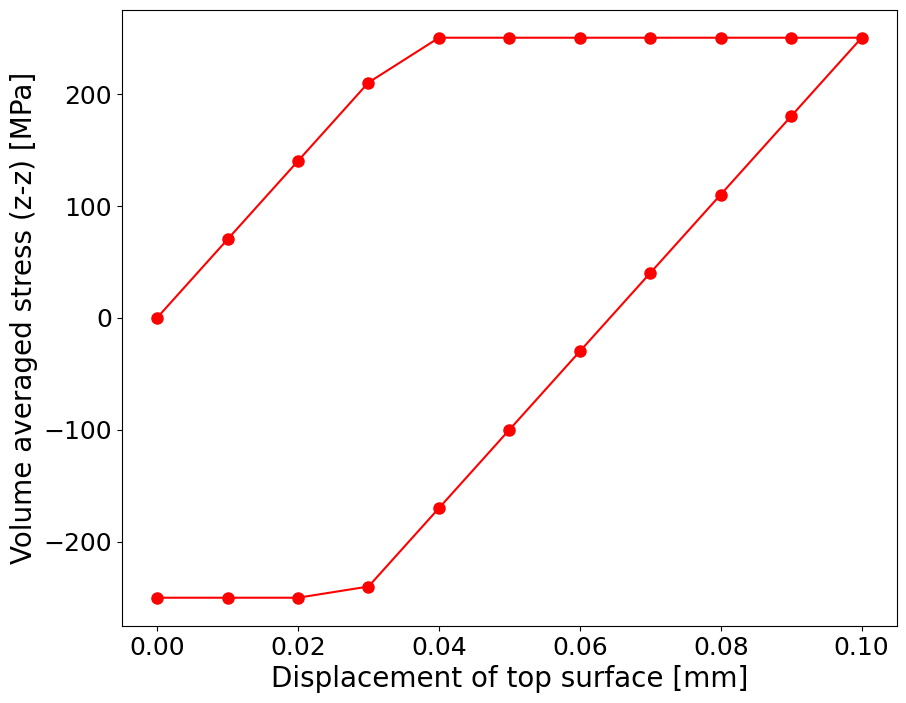

In [7]:
# Plot the volume-averaged stress versus the vertical displacement of the top surface.
fig = plt.figure(figsize=(10, 8))
plt.plot(disps, avg_stresses[:, 2, 2], color='red', marker='o', markersize=8, linestyle='-') 
plt.xlabel(r'Displacement of top surface [mm]', fontsize=20)
plt.ylabel(r'Volume averaged stress (z-z) [MPa]', fontsize=20)
plt.tick_params(labelsize=18)
plt.show()